In [1]:
#NEURAL STYLE TRANSFER WITH PyTORCH

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
#Choose GPU or cpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
#desired size of the output image

imsize= 768 if torch.cuda.is_available() else 128

loader= transforms.Compose([
    transforms.Resize(imsize), #Scale the image
    transforms.ToTensor()])    #Transform image to tensor

In [4]:
def image_loader(image_name):
    image= Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image= loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [214]:
style_img= image_loader(".\\NST_imgs\\misty-mood-leonid-afremov.jpg")
content_img= image_loader(".\\NST_imgs\\Dipping-Sun.jpg")

In [215]:
assert style_img.size()== content_img.size(), "we need to import style and content images of the same size"

In [216]:
#Display the images by converting them to PIL format

unloader= transforms.ToPILImage()

plt.ion()

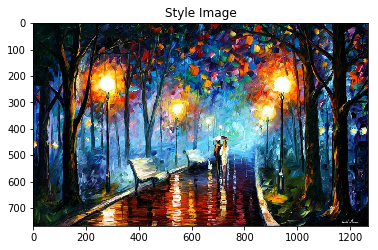

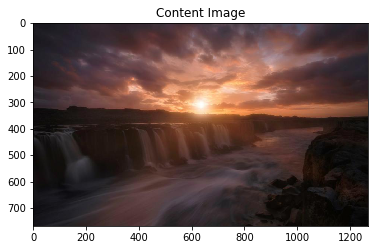

In [217]:
def imshow(tensor, title=None):
    image= tensor.cpu().clone()
    image= image.squeeze(0)
    image= unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
    
plt.figure()
imshow(style_img, "Style Image")

plt.figure()
imshow(content_img, "Content Image")

In [218]:
#Loss Functions

In [219]:
#Content Loss

class ContentLoss(nn.Module):
    def __init__(self, target):
                 super(ContentLoss, self).__init__()
                 self.target= target.detach()
                 
    def forward(self, input):
                 self.loss= F.mse_loss(input, self.target)
                 return input

In [220]:
#Style Loss

def gram_matrix(input):
    a, b, c, d =input.size()
    #a= batch size
    #b= number of feature maps
    #(c,d)= dimensions of f. map(N=c*d)
    features=input.view(a*b,c*d) # resize F_xl into \hat F_xl
    G= torch.mm(features, features.t()) #compute the gram product
    
    #Normalize the values of gram matrix by dividing the number of features of element in each matrix
    return G.div(a*b*c*d)

In [221]:
#The style distance is computed using the mean square error between G_xl and G_sl

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target= gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G= gram_matrix(input)
        self.loss= F.mse_loss(G, self.target)
        return input

In [222]:
#Importing Model VGG19

cnn= models.vgg19(pretrained=True).features.to(device).eval()


In [223]:
#VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
#We will use them to normalize the image before sending it into the network

In [224]:
cnn_normalization_mean= torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std= torch.tensor([0.229, 0.224, 0.225]).to(device)

In [225]:
#create a module to normalize input image so we can easily put it in a nn.Sequential

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view() the mean and std to make them [C x 1 x 1] so that they can directly work with image Tensor of shape 
        # [B x C x H x W]
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean= torch.tensor(mean).view(-1,1,1)
        self.std= torch.tensor(std).view(-1,1,1)
        
    def forward(self, img):
        #normalize image
        return (img - self.mean)/self.std

In [226]:
#desired depth layers  to compute style/compute losses
content_layers_default= ['conv_4']
style_layers_default= ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5_2']

In [227]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img,
                              content_layers=content_layers_default, style_layers= style_layers_default):
    cnn= copy.deepcopy(cnn)
    
    #normalization module
    normalization= Normalization(normalization_mean, normalization_std).to(device)
    
    #in order to have an iterable access to or list of content/syle losses
    content_losses=[]
    style_losses=[]
    
    #assuming that cnn is a nn.Sequential, so we make a new nn.Sequential to put in modules that are supposed 
    #to be activated sequentially
    model= nn.Sequential(normalization)
    
    i=0 #increment everytime we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i+=1
            name= 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name= 'relu_{}'.format(i)
            
            # The in-place version doesn't play very nicely with the ContentLoss and StyleLoss we insert below. 
            #So we replace with out-of-place ones here.
            layer= nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name='pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name= 'bn_{}'
        else:
            raise RuntimeError('Unrecognized Layer:{}'.format(layer.__class__.__name__))
            
        model.add_module(name, layer)
            
        if name in content_layers:
            #Add content loss:
            target= model(content_img).detach()
            content_loss= ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
                
        if name in style_layers:
            #Add style loss:
            target_feature= model(style_img).detach()
            style_loss= StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    
    #now we trim off the layers after the last content and style losses
    for i in range(len(model)-1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model=model[:(i+1)]
    
    return model, style_losses, content_losses
    

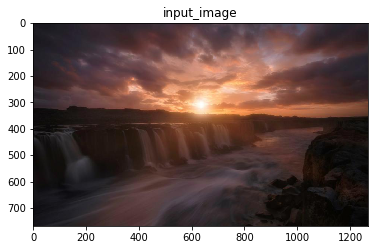

In [228]:
#we select the input image
#We can use a copy of the content image or white noise

input_img=content_img.clone()

#if we want to use white noise instead uncomment the below line:
imput_img= torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure
plt.figure()
imshow(input_img, title="input_image")

In [229]:
#Gradient Descent

#we will use L-BFGS algorithm to run our gradient descent

def get_input_optimizer(input_img):
    #input is a parameter that requires a gradient
    optimizer= optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [236]:
#Neural Transfer

def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img,
                      input_img, num_steps=100, style_weight=100000, content_weight=10):
    print("Building the style transfer model...")
    model, style_losses, content_losses= get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                                                   style_img, content_img)
    optimizer= get_input_optimizer(input_img)
    
    print("Optimizing...")
    run=[0]
    while run[0]<= num_steps:
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0,1)
            
            optimizer.zero_grad()
            model(input_img)
            style_score= 0
            content_score= 0
            
            for sl in style_losses:
                style_score+=sl.loss
            for cl in content_losses:
                content_score+=cl.loss
                
            style_score*=style_weight
            content_score*=content_weight
            
            loss= style_score + content_score
            loss.backward()
            
            run[0] +=1
            if run[0] % 50 == 0:
                print("run_{}".format(run))
                print("Style Loss: {:4f}  Content Loss: {:4f}".format(style_score.item(), content_score.item()))
                print()
                
            return style_score + content_score
        
        optimizer.step(closure)
    
    # last correction...
    input_img.data.clamp_(0,1)
    
    return input_img

Building the style transfer model...
Optimizing...
run_[50]
Style Loss: 28.114017  Content Loss: 92.258667

run_[100]
Style Loss: 28.167988  Content Loss: 92.252663



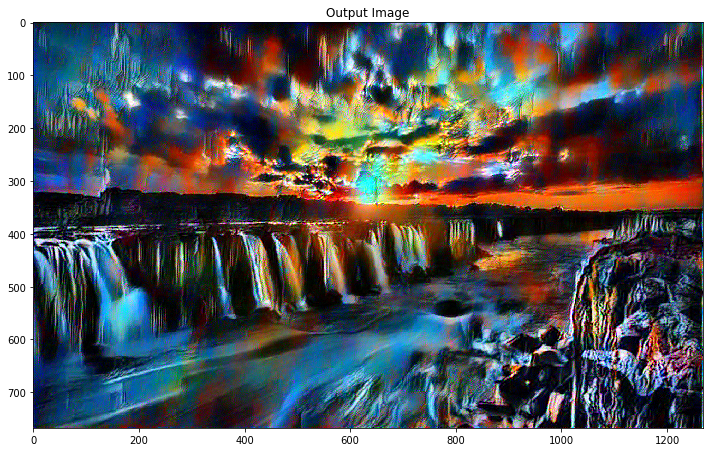

In [237]:
output =run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)

plt.figure(figsize=(12,12))
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()